#Ch01. 탬플릿 설명

##1.리포지토리 클론 및 설치

https://github.com/victoresque/pytorch-template

```
git clone https://github.com/victoresque/pytorch-template.git
cd pytorch-template
pip install -r requirements.txt
```



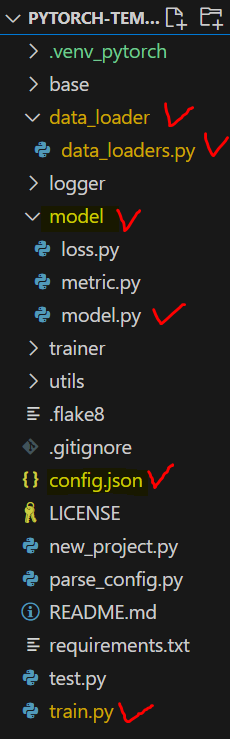

##2.data_loader 데이터셋 준비

data_loader 폴더에 있는 data_loaders.py 파일을 수정하여 MNIST 데이터셋 로드

In [ ]:
# torchvision.datasets: PyTorch의 데이터셋 모듈로, 여러 가지 유명한 데이터셋을 쉽게 로드할 수 있음.
# torchvision.transforms: 데이터 전처리 및 변환을 위한 모듈.
# base.BaseDataLoader: 템플릿 프로젝트에서 제공하는 기본 데이터 로더 클래스.
from torchvision import datasets, transforms
from base import BaseDataLoader

#MnistDataLoader 클래스는 BaseDataLoader를 상속받아 사용

class MnistDataLoader(BaseDataLoader):
    """
    MNIST data loading demo using BaseDataLoader
    """
    def __init__(self, data_dir, batch_size, shuffle=True, validation_split=0.0, num_workers=1, training=True):
        # 데이터 전처리를 위한 변환 파이프라인 설정
        # transforms.Compose: 여러 가지 변환을 순차적으로 적용
        trsfm = transforms.Compose([
            transforms.ToTensor(),   # 이미지 데이터를 텐서(tensor)로 변환
            transforms.Normalize((0.1307,), (0.3081,))  # 데이터 정규화
        ])

        # 데이터셋 경로 설정
        self.data_dir = data_dir

        # MNIST 데이터셋 로드
        self.dataset = datasets.MNIST(self.data_dir, train=training, download=True, transform=trsfm)

        # 부모 클래스(BaseDataLoader)의 초기화 함수 호출
        super().__init__(self.dataset, batch_size, shuffle, validation_split, num_workers)



##3.model 모델정의

model 폴더에 있는 model.py 파일을 수정하여 MLP 모델 정의

> MnistModel 클래스를 정의하여 MNIST 데이터셋을 분류하는 CNN(Convolutional Neural Network) 모델 구현 코드

* MnistModel 클래스는 MNIST 데이터셋을 분류하기 위해 설계된 CNN 모델입니다.
* 합성곱 레이어: 특징을 추출하는 두 개의 합성곱 레이어를 포함합니다.
* 풀링 레이어: 특징 맵의 크기를 줄이기 위해 맥스 풀링을 사용합니다.
* 드롭아웃 레이어: 과적합을 방지하기 위해 드롭아웃을 사용합니다.
* 완전 연결 레이어: 추출된 특징을 사용하여 분류를 수행합니다.
* 순전파 단계: 입력 데이터를 레이어를 통해 순차적으로 전달하여 최종 분류 결과를 얻습니다.

이 모델은 MNIST와 같은 이미지 분류 작업에서 사용되며, 합성곱 레이어와 풀링 레이어를 통해 특징을 추출하고 완전 연결 레이어를 통해 분류를 수행

In [ ]:
# torch.nn: PyTorch의 신경망 모듈로, 다양한 신경망 레이어를 제공.
# torch.nn.functional: PyTorch의 함수형 API로, 활성화 함수 및 기타 신경망 연산을 제공.
# base.BaseModel: 템플릿 프로젝트에서 제공하는 기본 모델 클래스. 이를 상속받아 모델을 정의.
import torch.nn as nn
import torch.nn.functional as F
from base import BaseModel


class MnistModel(BaseModel):
    def __init__(self, num_classes=10):
        super().__init__()   # 부모 클래스인 BaseModel의 초기화 함수를 호출
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)   # 첫 번째 합성곱(Convolutional) 레이어. 입력 채널 수는 1, 출력 채널 수는 10, 커널 크기는 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()   # 드롭아웃(Dropout) 레이어. 2D 입력에 드롭아웃을 적용
        self.fc1 = nn.Linear(320, 50)   #첫 번째 완전 연결(Fully Connected) 레이어
        self.fc2 = nn.Linear(50, num_classes)   #두 번째 완전 연결 레이어 (num_classes 기본값 10 - 출력크기)

    # forward: 모델의 순전파(Forward) 단계를 정의
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))   # 첫 번째 합성곱 레이어를 거친 후 ReLU 활성화 함수를 적용하고, 2x2 맥스 풀링을 적용
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))   # 두 번째 합성곱 레이어를 거친 후 드롭아웃을 적용, ReLU 활성화 함수를 적용한 후 2x2 맥스 풀링을 적용
        x = x.view(-1, 320)   #텐서를 일렬로 펼침. 여기서 -1은 자동으로 배치 크기에 맞추어 주며, 320은 각 샘플의 특징 수
        x = F.relu(self.fc1(x))   #첫 번째 완전 연결 레이어를 거친 후 ReLU 활성화 함수를 적용
        x = F.dropout(x, training=self.training)   #모델이 학습 중일 때만 드롭아웃 적용
        x = self.fc2(x)   # 두 번째 완전 연결 레이어
        return F.log_softmax(x, dim=1)


##4.config.json 손실 함수와 최적화 알고리즘 설정
config.json 파일에서 설정 정의

In [ ]:
{
    "name": "Mnist_LeNet",        # 실험 이름
    "n_gpu": 1,                   # 사용할 GPU수 1개

    "arch": {                     # 모델 아키텍처 설정
        "type": "MnistModel",     # 사용할 모델 클래스 이름 지정
        "args": {}                # 모델 클래스에 전달할 추가 인자: 빈 객체
    },
    "data_loader": {               # 데이터 로더 설정
        "type": "MnistDataLoader", # 사용할 데이터 로더의 클래스 이름
        "args":{
            "data_dir": "data/",   # 데이터가 저장될 디렉토리
            "batch_size": 128,     # 배치크기
            "shuffle": true,       # 데이터를 셔플할지 여부
            "validation_split": 0.1,   # 검증데이터로 사용할 비율
            "num_workers": 2       # 데이터 로딩에 사용될 워커(worker)수
        }
    },
    "optimizer": {                  # 옵티마이저 설정
        "type": "Adam",             # 사용할 옵티마이저 타입
        "args":{
            "lr": 0.001,            # 학습률
            "weight_decay": 0,      # 가중치 감소
            "amsgrad": true         # AMSGrad 변형을 사용할지 여부
        }
    },
    "loss": "nll_loss",              # 사용할 손실함수 타입 지정
    "metrics": [                     # 평가에 사용할 메트릭 설정
        "accuracy", "top_k_acc"
    ],
    "lr_scheduler": {                # 학습률 스케줄러 설정
        "type": "StepLR",            # 사용할 학습 스케줄러 타입
        "args": {
            "step_size": 50,         # 학습률을 감소시킬 에포크 간격
            "gamma": 0.1             # 학습률을 감소시키는 비율
        }
    },
    "trainer": {                      # 트레이너 설정
        "epochs": 100,                # 학습할 에포크 수

        "save_dir": "saved/",         # 모델이 저장될 디렉토리
        "save_period": 1,             # 모델을 저장할 주기(에포크)
        "verbosity": 2,               # 출력의 상세도

        "monitor": "min val_loss",    # 조기 종료를 모니터링할 메트릭
        "early_stop": 10,             # 조기 종료를 위한 기준 에포크 수

        "tensorboard": true           # Tensorboard 사용 여부
    }
}


##5.학습 및 평가

아래 스크립트는 다음과 같은 주요 단계를 수행합니다:

1. 라이브러리와 모듈을 임포트하고, 난수 시드를 고정.
2. 구성 파일을 기반으로 데이터 로더, 모델, 손실 함수, 메트릭, 옵티마이저, 학습률 스케줄러를 설정.
3. Trainer 클래스를 사용하여 모델을 학습하고 평가.
4. 명령줄 인자를 통해 구성 파일의 설정을 동적으로 변경할 수 있도록.


> train.py 스크립트를 사용하여 모델을 학습

In [ ]:
import argparse
import collections
import torch
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from trainer import Trainer
from utils import prepare_device


# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# 데이터 로더 설정: config.init_obj를 사용하여 데이터 로더 인스턴스를 생성하고, 검증 데이터 로더를 설정.
# 모델 아키텍처 구축: 구성 파일에 정의된 모델 아키텍처를 초기화하고 로그에 출력.
# GPU 준비: GPU를 설정하고, 모델을 GPU로 이동시킵니다. 여러 GPU를 사용할 경우 torch.nn.DataParallel을 사용하여 병렬 처리.
# 손실 함수 및 메트릭 설정: 구성 파일에 정의된 손실 함수와 메트릭을 가져오기.
# 옵티마이저 및 학습률 스케줄러 설정: 구성 파일에 정의된 옵티마이저와 학습률 스케줄러를 초기화.
# 트레이너 초기화 및 학습 시작: Trainer 클래스를 초기화하고 학습을 시작.
def main(config):
    logger = config.get_logger('train')

    # setup data_loader instances
    data_loader = config.init_obj('data_loader', module_data)
    valid_data_loader = data_loader.split_validation()

    # build model architecture, then print to console
    model = config.init_obj('arch', module_arch)
    logger.info(model)

    # prepare for (multi-device) GPU training
    device, device_ids = prepare_device(config['n_gpu'])
    model = model.to(device)
    if len(device_ids) > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)

    # get function handles of loss and metrics
    criterion = getattr(module_loss, config['loss'])
    metrics = [getattr(module_metric, met) for met in config['metrics']]

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
    lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

    trainer = Trainer(model, criterion, metrics, optimizer,
                      config=config,
                      device=device,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler)

    trainer.train()

# argparse 설정: 명령줄 인자 파서를 설정
#    -c 또는 --config: 구성 파일의 경로를 지정.
#    -r 또는 --resume: 체크포인트 파일의 경로를 지정하여 중단된 지점에서 학습을 재개.
#    -d 또는 --device: 사용할 GPU의 인덱스를 지정.
# 커스텀 명령줄 옵션 설정: 구성 파일의 기본 값을 명령줄 인자를 통해 수정할 수 있도록 설정.
#    --lr 또는 --learning_rate: 학습률을 설정.
#    --bs 또는 --batch_size: 배치 크기를 설정.
# ConfigParser 초기화: 명령줄 인자와 옵션을 기반으로 구성 파일을 파싱하고 ConfigParser 객체를 생성.
# main 함수 호출: 구성 파일을 인자로 하여 main 함수를 호출.
if __name__ == '__main__':
    args = argparse.ArgumentParser(description='PyTorch Template')
    args.add_argument('-c', '--config', default=None, type=str,
                      help='config file path (default: None)')
    args.add_argument('-r', '--resume', default=None, type=str,
                      help='path to latest checkpoint (default: None)')
    args.add_argument('-d', '--device', default=None, type=str,
                      help='indices of GPUs to enable (default: all)')

    # custom cli options to modify configuration from default values given in json file.
    CustomArgs = collections.namedtuple('CustomArgs', 'flags type target')
    options = [
        CustomArgs(['--lr', '--learning_rate'], type=float, target='optimizer;args;lr'),
        CustomArgs(['--bs', '--batch_size'], type=int, target='data_loader;args;batch_size')
    ]
    config = ConfigParser.from_args(args, options)
    main(config)


# Ch02. 활용방법

##1.하이퍼파라미터 조정

config.json 파일 수정



```
주요 하이퍼파라미터 조정 설명

1. data_loader:

* batch_size: 배치 크기를 조정하면 학습 속도와 메모리 사용량에 영향을 줍니다. 예를 들어, 메모리가 충분하다면 더 큰 배치 크기를 사용할 수 있습니다.
* validation_split: 검증 데이터셋의 비율을 조정하여 모델의 검증 성능을 평가하는 데 사용합니다.
* num_workers: 데이터 로딩에 사용할 CPU 코어 수를 설정합니다. 더 많은 코어를 사용하면 데이터 로딩 속도가 빨라질 수 있습니다.

2. optimizer:

* lr: 학습률을 조정하여 모델의 가중치 업데이트 크기를 결정합니다. 일반적으로 작은 값(예: 0.0001~0.01)에서 시작하여 적절한 값을 찾습니다.
* weight_decay: 가중치 감쇠를 사용하여 과적합을 방지합니다. 일반적으로 작은 값(예: 0.0001)을 사용합니다.


3. lr_scheduler:

* step_size: 학습률 감소 주기를 설정합니다. 예를 들어, 50 에포크마다 학습률을 감소시킵니다.
* gamma: 학습률 감소 비율을 설정합니다. 예를 들어, gamma가 0.1이면 학습률이 10%로 감소합니다.

4. trainer:

* epochs: 총 학습 에포크 수를 조정합니다. 더 많은 에포크는 모델이 데이터셋을 더 많이 학습하게 하지만, 과적합의 위험도 있습니다.
* early_stop: 조기 종료 기준을 설정하여 검증 손실이 개선되지 않으면 학습을 조기 종료할 수 있습니다.
* tensorboard: 텐서보드를 사용하여 학습 과정을 시각화할 수 있습니다.
```




In [ ]:
{
    "name": "Mnist_LeNet",
    "n_gpu": 1,

    "arch": {
        "type": "MnistModel",
        "args": {}
    },
    "data_loader": {
        "type": "MnistDataLoader",
        "args":{
            "data_dir": "data/",
            "batch_size": 64,  // 배치 크기 조정
            "shuffle": true,
            "validation_split": 0.1,
            "num_workers": 2
        }
    },
    "optimizer": {
        "type": "Adam",
        "args":{
            "lr": 0.0005,  // 학습률 조정
            "weight_decay": 0.0001,  // 가중치 감쇠 추가
            "amsgrad": true
        }
    },
    "loss": "nll_loss",
    "metrics": [
        "accuracy", "top_k_acc"
    ],
    "lr_scheduler": {
        "type": "StepLR",
        "args": {
            "step_size": 20,  // 학습률 감소 주기 조정
            "gamma": 0.1
        }
    },
    "trainer": {
        "epochs": 50,  // 에포크 수 조정

        "save_dir": "saved/",
        "save_period": 1,
        "verbosity": 2,

        "monitor": "min val_loss",
        "early_stop": 10,

        "tensorboard": true
    }
}


##2.모델 커스터마이징

기본적인 MLP 모델 외에도 다양한 네트워크 구조를 실험해 볼 수 있습니다. 예를 들어, 더 깊은 네트워크나 다른 활성화 함수를 사용할 수 있습니다.

model/model.py 예시 (커스터마이징된 MLP 모델)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  // 128에서 256으로 변경
        self.fc2 = nn.Linear(256, 128)  // 64에서 128으로 변경
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


##3.성능 향상 기법

1. 정규화 (Normalization) : data_loader/data_loaders.py에서 transforms.Normalize 사용 중
2. 드롭아웃 (Dropout) : 과적합(overfitting)을 방지하기 위해 드롭아웃을 사용
3. 배치 정규화 (Batch Normalization) : 배치 정규화를 통해 학습을 가속화하고 안정화할 수 있음

### 정규화(Normalization)

: data_loader/data_loaders.py에서 transforms.Normalize 사용 중

### 드롭아웃 (Dropout) 예시

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=0.5)  // 드롭아웃 레이어 추가

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  // 드롭아웃 적용
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### 배치 정규화 (Batch Normalization) 예시

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  // 배치 정규화 레이어 추가
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)  // 배치 정규화 레이어 추가
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))  // 배치 정규화 적용
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))  // 배치 정규화 적용
        x = self.fc3(x)
        return x


##4.추가적인 커스터마이징

* 텐서보드 (TensorBoard)

config.json에서 "tensorboard": true로 설정하면 텐서보드 로그를 남길 수 있습니다. 텐서보드를 사용하여 학습 과정을 시각화할 수 있습니다.



```
tensorboard --logdir saved/runs/

```



##5.다양한 최적화 알고리즘 실험

Adam 외에도 SGD, RMSprop 등 다양한 최적화 알고리즘을 실험해 볼 수 있습니다.

config.json 예시 (SGD 사용)

In [ ]:
"optimizer": {
  "type": "SGD",
  "args": {
    "lr": 0.01,
    "momentum": 0.9
  }
}
